# Attempting to diagnose TCR

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
from os.path import join, expanduser
from glob import glob

import numpy as np
import pymagicc
from pymagicc import rcp26, write_scen_file, _get_date_time_string
from pymagicc.input import MAGICCInput
from pymagicc.api import MAGICC6

In [3]:
MAGICC6_DIR = expanduser(join('~', 'Desktop', 'MAGICC6', ))
MAGICC6_RUN_DIR = join(MAGICC6_DIR, 'run', )

In [4]:
mi = MAGICCInput()
mi.read(filepath=MAGICC6_RUN_DIR, filename='HISTRCP_CO2_CONC.IN')

In [44]:
mi.metadata['header'] = '\n'.join([
    'TCR Diagnosis input file',
    'Written by: diagnose-tcr notebook in pymagicc package'
]) + '\n\n'
mi.df = mi.df.loc[mi.df.index.values[0][:-1] + (slice(1600, 2008),)]
mi.df.head()

VARIABLE  TODO  REGION  UNITS  YEAR
CO2_CONC  SET   GLOBAL  ppm    1600    276.333846
                               1601    276.333846
                               1602    276.333846
                               1603    276.333846
                               1604    276.333846
dtype: float64

VARIABLE  TODO  REGION  UNITS  YEAR
CO2_CONC  SET   GLOBAL  ppm    1600    276.333846
                               1601    276.333846
                               1602    276.333846
                               1603    276.333846
                               1604    276.333846
dtype: float64

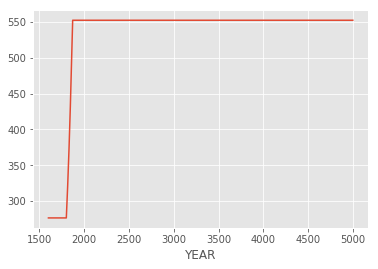

In [45]:
# working with this df is unreasonably difficult at the moment, something to fix...
PI_CO2 = mi.df.loc[mi.df.index.values[0]]
mi.df.loc[mi.df.index.values[0][:-1] + (slice(1010, 1800),)] = PI_CO2
mi.df.loc[mi.df.index.values[0][:-1] + (slice(1800, 1870),)] = PI_CO2 * 1.01**np.arange(0,71)
mi.df.loc[mi.df.index.values[0][:-1] + (slice(1870, 2008),)] = PI_CO2 * 2.
# this takes like 15 seconds but I can't work out a smart way to do it...
for i in range(2008, 5001):
    mi.df.loc[mi.df.index.values[0][:-1] + (i,)] = PI_CO2 * 2.
ax = mi.df.loc[mi.df.index.values[0][:-1]].plot()
mi.df.head()

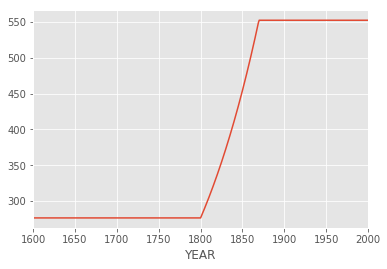

In [46]:
ax = mi.df.loc[mi.df.index.values[0][:-1]].plot()
ax.set_xlim([1600,2000]);

In [8]:
tcr_prefix = 'HISTTCR'
co2_tcr_conc_file = tcr_prefix + '_CO2_CONC.IN'

tcr_config = {}
tcr_config["FILE_CO2_CONC"] = co2_tcr_conc_file
mi.write(join(MAGICC6_RUN_DIR , tcr_config["FILE_CO2_CONC"]))

In [69]:
with MAGICC6(root_dir=MAGICC6_DIR) as magicc:
    write_scen_file(rcp26, join(magicc.run_dir, "SCENARIO.SCEN"))
    
    magicc.set_years(startyear=1750, endyear=4200) # 4200 seems to be the max I can push too without an error
    
    tcr_config.setdefault("rundate", _get_date_time_string())
    tcr_config["FILE_CO2_CONC"] = co2_tcr_conc_file
    tcr_config["RF_TOTAL_RUNMODUS"] = "CO2"
    tcr_config["RF_TOTAL_CONSTANTAFTERYR"] = 2000
    magicc.set_config(**tcr_config)

    results = magicc.run(only=['SURFACE_TEMP', 'CO2_CONC', 'TOTAL_INCLVOLCANIC_RF'])

In [75]:
results['SURFACE_TEMP']['GLOBAL'].head()

YEARS
1750    0.0
1751    0.0
1752    0.0
1753    0.0
1754    0.0
Name: GLOBAL, dtype: float64

TCR: 1.970709K
ECS: 2.9823991000000003K


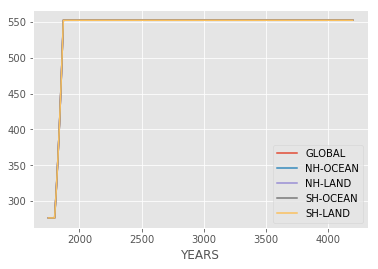

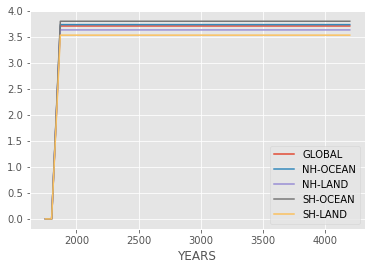

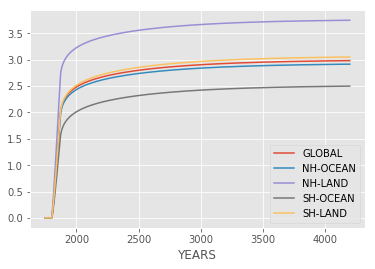

In [74]:
print("TCR: {}K".format(results['SURFACE_TEMP']['GLOBAL'].loc[1870]))
print("ECS: {}K".format(results['SURFACE_TEMP']['GLOBAL'].loc[4199]))
results['CO2_CONC'].plot()
results['TOTAL_INCLVOLCANIC_RF'].plot()
results['SURFACE_TEMP'].plot();

In [93]:
import pandas as pd
mock_tcr_val = 1.8
mock_tcr_yr = 1825
mock_ecs_val = 3.1
mock_ecs_yr = 2200

mock_res = {}
mock_res = {}
mock_res['SURFACE_TEMP'] = pd.DataFrame(
    {'GLOBAL': np.zeros(len(fake_time))},
    index=fake_time,
)
mock_res['SURFACE_TEMP']['GLOBAL'].loc[mock_tcr_yr] = mock_tcr_val
mock_res['SURFACE_TEMP']['GLOBAL'].loc[mock_ecs_yr] = mock_ecs_val
mock_res['SURFACE_TEMP']['GLOBAL'].loc[mock_ecs_yr]

3.1

In [90]:
results

{'CO2_CONC':           GLOBAL   NH-OCEAN    NH-LAND   SH-OCEAN    SH-LAND
 YEARS                                                       
 1750   276.33385  276.33385  276.33385  276.33385  276.33385
 1751   276.33385  276.33385  276.33385  276.33385  276.33385
 1752   276.33385  276.33385  276.33385  276.33385  276.33385
 1753   276.33385  276.33385  276.33385  276.33385  276.33385
 1754   276.33385  276.33385  276.33385  276.33385  276.33385
 1755   276.33385  276.33385  276.33385  276.33385  276.33385
 1756   276.33385  276.33385  276.33385  276.33385  276.33385
 1757   276.33385  276.33385  276.33385  276.33385  276.33385
 1758   276.33385  276.33385  276.33385  276.33385  276.33385
 1759   276.33385  276.33385  276.33385  276.33385  276.33385
 1760   276.33385  276.33385  276.33385  276.33385  276.33385
 1761   276.33385  276.33385  276.33385  276.33385  276.33385
 1762   276.33385  276.33385  276.33385  276.33385  276.33385
 1763   276.33385  276.33385  276.33385  276.33385  276.33